In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [2]:
# 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from statsmodels.tsa.stattools import adfuller

In [1]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

IndexError: list index out of range

In [8]:
from tsfresh import extract_features

IndexError: list index out of range

In [9]:
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

IndexError: list index out of range

In [14]:

# 비정상 데이터를 정상 데이터로 만들기
ap = pd.read_csv('AirPassengers.csv')

In [15]:

# 'Month' column 삭제
ap = ap.drop(columns=['Month'])

In [16]:

# 데이터 확인
print(ap.head())

   #Passengers
0          112
1          118
2          132
3          129
4          121


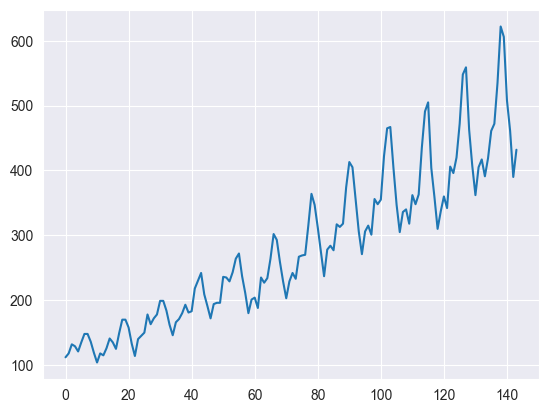

In [17]:

# 시각화
plt.figure()
plt.plot(ap)
plt.show()

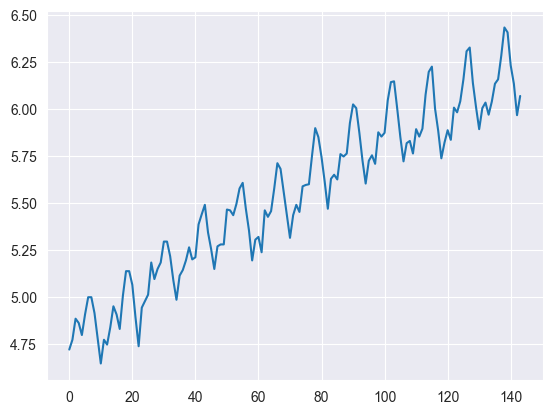

In [18]:

# 분산 일정하게 만들기 - log transformation
log_transformed = np.log(ap['#Passengers'])

plt.figure()
plt.plot(log_transformed)
plt.show()

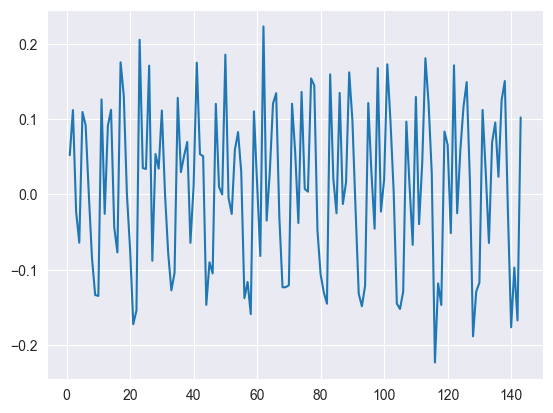

In [19]:

# 차분을 통해 추세 제거하기
diffed = log_transformed.diff().dropna()

plt.figure()
plt.plot(diffed)
plt.show()

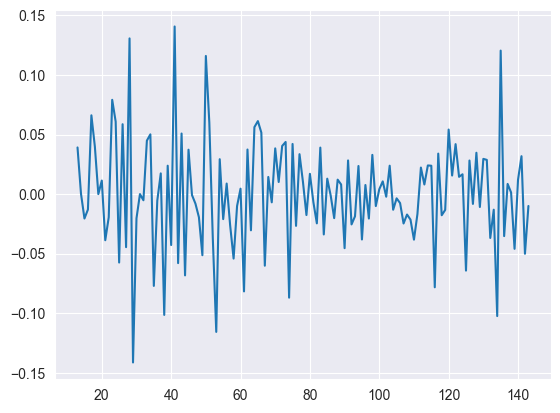

In [20]:

# 계절 차분을 통해 계절성 제거하기
seasonally_diffed = diffed.diff(12).dropna()

plt.figure()
plt.plot(seasonally_diffed)
plt.show()

In [21]:

# 정상성 검정 (ADF Test)
def adf_test(x):
    stat, p_value, lags, nobs, crit, icb = adfuller(x)
    print("ADF statistics:", stat)
    print("P-value:", p_value)

adf_test(seasonally_diffed)

ADF statistics: -4.4433249418311185
P-value: 0.00024859123113840924


In [22]:

# 시계열 분류
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

NameError: name 'download_robot_execution_failures' is not defined

In [ ]:

# 데이터셋 확인
print(timeseries.head())
print(y.head())

In [ ]:

# 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3):

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)
    y_test = y.loc[id_list]
    X_train = x.drop(id_list)
    X_test = x.loc[id_list]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [ ]:

# Feature extraction
settings = EfficientFCParameters()
comprehensive_features_train = extract_features(
    X_train, column_id="id", column_sort="time", default_fc_parameters=settings
)
comprehensive_features_test = extract_features(
    X_test, column_id="id", column_sort="time", default_fc_parameters=settings
)

In [ ]:

# impute
impute(comprehensive_features_train)
impute(comprehensive_features_test)

In [ ]:

# RandomForest 모델 학습 및 평가
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=3)
rf_clf.fit(comprehensive_features_train, y_train)
print("RandomForest Score:", rf_clf.score(comprehensive_features_test, y_test))

In [ ]:

# XGBoost 모델 학습 및 평가
xgb_clf = xgb.XGBClassifier(n_estimators=10, max_depth=3)
xgb_clf.fit(comprehensive_features_train, y_train)
print("XGBoost Score:", xgb_clf.score(comprehensive_features_test, y_test))

In [ ]:

# 중요도 시각화
xgb.plot_importance(xgb_clf, importance_type='gain')
plt.show()

In [ ]:

# Classification report
report = classification_report(
    y_test, xgb_clf.predict(comprehensive_features_test),
    target_names=['false', 'true'], output_dict=True
)
print(report)
